In [2]:
import json
import pickle
import sys
import os

# hack so we can import normally from other packages
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
PROJ_PATH = "/sciclone/proj-ds/geograd/stmorse/mdp"

## baseline vs mcts

In [36]:
v0 = 0.8
turns = 4
exp_name = "fender/fenderh_full"

# trees (one for each turn)
roots = []
for turn in range(4):
    path = f"{exp_name}/v0_{v0:.2f}_v1_1.00/turn_{turn}_root.pkl"
    with open(os.path.join(PROJ_PATH, path), "rb") as f:
        roots.append(pickle.load(f))

# embeddings + labels
path = f"{exp_name}/v0_{v0:.2f}_v1_1.00/embed.pkl"
with open(os.path.join(PROJ_PATH, path), "rb") as f:
    output = pickle.load(f)
print(output.keys())

# get final turn conversation
path = f"{exp_name}/v0_{v0:.2f}_v1_1.00/turn_{turns-1}.json"
with open(os.path.join(PROJ_PATH, path), "r") as f:
    record = json.load(f)
print(record.keys())

# scenario deets
with open("../scenarios/fender.json", "r") as f:
    scenario = json.load(f)

dict_keys(['embeddings', 'probs', 'texts', 'labels', 'meta'])
dict_keys(['records', 'results', 'response', 'state'])


In [37]:
exp2_name = "fender/fenderh_base"

# embeddings + labels
path = f"{exp2_name}/v0_{v0:.2f}_v1_1.00/embed.pkl"
with open(os.path.join(PROJ_PATH, path), "rb") as f:
    output2 = pickle.load(f)
print(output2.keys())

# get final turn conversation
path = f"{exp2_name}/v0_{v0:.2f}_v1_1.00/turn_{turns-1}.json"
with open(os.path.join(PROJ_PATH, path), "r") as f:
    record2 = json.load(f)
print(record2.keys())

dict_keys(['embeddings', 'probs', 'texts', 'labels', 'meta'])
dict_keys(['records', 'results', 'response', 'state'])


In [38]:
output["embeddings"].shape, len(output["labels"]), len(output["texts"])

((1451, 1024), 1440, 1451)

In [39]:
output2["embeddings"].shape, len(output2["texts"])

((11, 1024), 11)

In [40]:
all_embeddings = np.vstack([output["embeddings"], output2["embeddings"]])
epca = PCA(n_components=100).fit_transform(all_embeddings)
etsne = TSNE(n_components=2).fit_transform(epca)

In [41]:
# indices within all_embeddings / etsne

# conversation 1
s_c1 = 0
e_c1 = 9

# tree indices
s_t = e_c1
e_t = e_c1 + len(output["labels"])

# conversation 2
s_c2 = e_t + 2  # account for persona
e_c2 = s_c2 + 9

print(s_c1, e_c1, s_t, e_t, s_c2, e_c2)

0 9 9 1449 1451 1460


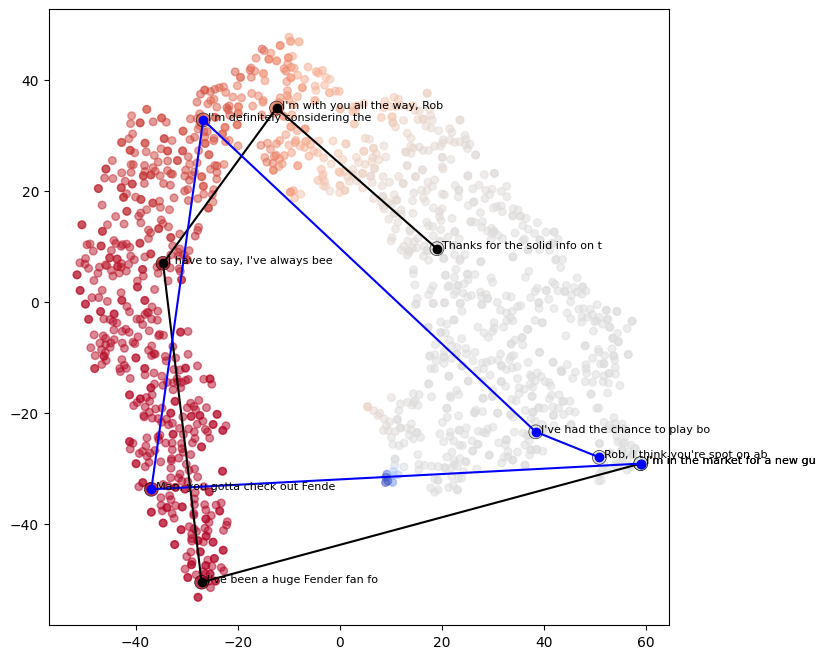

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
norm = Normalize(vmin=-1, vmax=1)

# --- full MCTS scatter ---
entail_probs = output["probs"][s_t:e_t,0] - output["probs"][s_t:e_t,2]
et_slice = etsne[s_t:e_t,:]
ax.scatter(
    et_slice[:,0], et_slice[:,1], 
    s=30, 
    c=entail_probs,
    cmap="coolwarm",
    norm=norm,
    alpha=0.5
)

# --- CONVO 1 ---
entail_probs = output["probs"][s_c1:e_c1,0] - output["probs"][s_c1:e_c1,2]
et_slice = etsne[s_c1:e_c1,:]

# plot agent 0
ax.scatter(
    et_slice[::2,0], et_slice[::2,1],
    s=100, edgecolors='black', linewidths=0.5,
    c=entail_probs[::2], 
    cmap="coolwarm",
    norm=norm,
    alpha=0.8
)
ax.plot(et_slice[::2,0], et_slice[::2,1], 'ko-')

for i in range(s_c1, e_c1, 2):
    msg = output["texts"][i]
    vec = etsne[i]
    ax.text(vec[0]+1, vec[1], msg[:30], fontsize=8)

# --- CONVO 2 ---
entail_probs = output2["probs"][:9,0] - output2["probs"][:9,2]
et_slice = etsne[s_c2:e_c2,:]

# plot agent 0
ax.scatter(
    et_slice[::2,0], et_slice[::2,1],
    s=100, edgecolors='black', linewidths=0.5,
    c=entail_probs[::2], 
    cmap="coolwarm",
    norm=norm,
    alpha=0.8
)
ax.plot(et_slice[::2,0], et_slice[::2,1], 'bo-')

for k, i in enumerate(range(s_c2, e_c2, 2)):
    msg = output2["texts"][k]
    vec = etsne[i]
    ax.text(vec[0]+1, vec[1], msg[:30], fontsize=8)

plt.show()

In [7]:
turns = 4
convo_length = (turns * 2) + 1

exp_name = "fender/fenderh_full"
exp2_name = "fender/fenderh_base"

mcts_probs = []  # row: valence, col: step
base_probs = []  

v0s = np.array([-1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

for v0 in v0s:

    # embeddings + labels
    path = f"{exp_name}/v0_{v0:.2f}_v1_1.00/embed.pkl"
    with open(os.path.join(PROJ_PATH, path), "rb") as f:
        output = pickle.load(f)

    p = output["probs"][:convo_length,0] - output["probs"][:convo_length,2]
    mcts_probs.append(p.reshape((1,-1)).copy())

    # embeddings + labels
    path = f"{exp2_name}/v0_{v0:.2f}_v1_1.00/embed.pkl"
    with open(os.path.join(PROJ_PATH, path), "rb") as f:
        output2 = pickle.load(f)

    p = output2["probs"][:convo_length,0] - output2["probs"][:convo_length,2]
    base_probs.append(p.reshape((1,-1)).copy())

mcts_probs = np.vstack(mcts_probs)
base_probs = np.vstack(base_probs)

mcts_probs.shape, base_probs.shape

((12, 9), (12, 9))

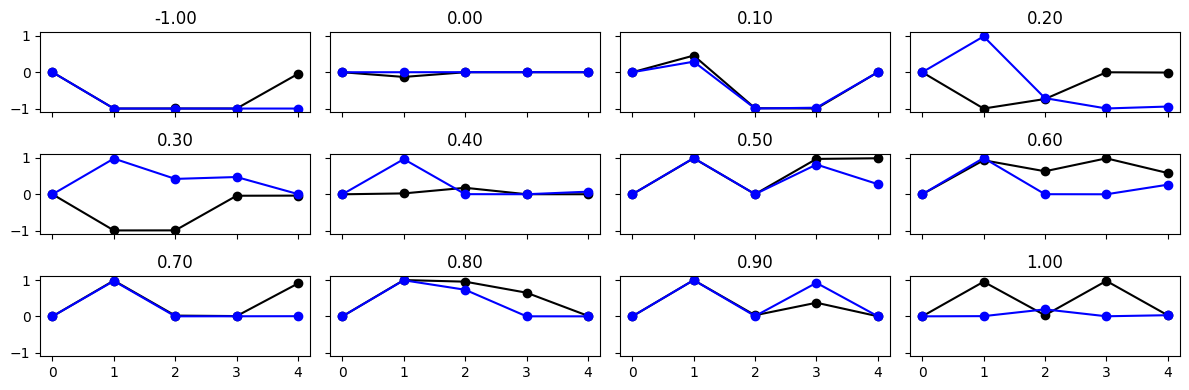

In [8]:
fig, axs = plt.subplots(3,4, figsize=(12,4), sharey=True, sharex=True)

for i, ax in enumerate(axs.ravel()):
    p1_slice = mcts_probs[i,::2]
    p2_slice = base_probs[i,::2]

    ax.plot(range(turns+1), p1_slice, 'ko-')
    ax.plot(range(turns+1), p2_slice, 'bo-')

    ax.set_title(f"{v0s[i]:.2f}")

plt.tight_layout()

## multiple at same valence

In [11]:
v0 = 0.5
turns = 4
convo_length = (turns * 2) + 1

exp_name = "fender/fenderh_full_mult"
exp2_name = "fender/fenderh_base_mult"

mcts_probs = []  # row: valence, col: step
base_probs = []  

offsets = np.arange(12)

for off in offsets:

    # embeddings + labels
    path = f"{exp_name}/v0_{v0:.2f}_v1_1.00/_{off}/embed.pkl"
    with open(os.path.join(PROJ_PATH, path), "rb") as f:
        output = pickle.load(f)

    p = output["probs"][:convo_length,0] - output["probs"][:convo_length,2]
    mcts_probs.append(p.reshape((1,-1)).copy())

    # embeddings + labels
    path = f"{exp2_name}/v0_{v0:.2f}_v1_1.00/_{off}/embed.pkl"
    with open(os.path.join(PROJ_PATH, path), "rb") as f:
        output2 = pickle.load(f)

    p = output2["probs"][:convo_length,0] - output2["probs"][:convo_length,2]
    base_probs.append(p.reshape((1,-1)).copy())

mcts_probs = np.vstack(mcts_probs)
base_probs = np.vstack(base_probs)

mcts_probs.shape, base_probs.shape

((12, 9), (12, 9))

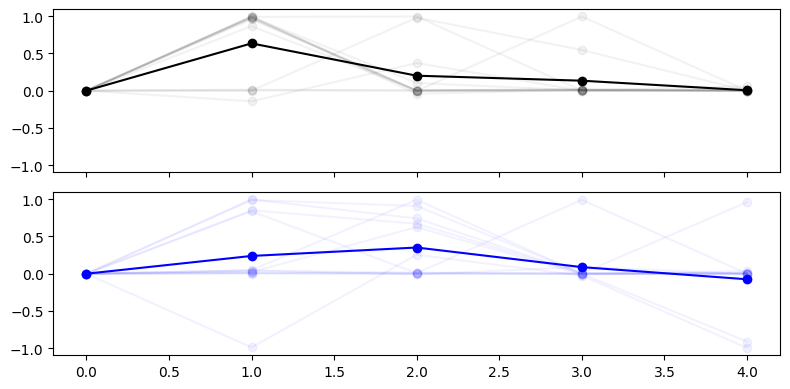

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(8,4), sharey=True, sharex=True)

p1 = mcts_probs[:,::2]
for s in range(p1.shape[0]):
    axs[0].plot(range(turns+1), p1[s,:], 'ko-', alpha=0.05)
axs[0].plot(range(turns+1), np.average(p1[:,:], axis=0), 'ko-')

p1 = base_probs[:,::2]
for s in range(p1.shape[0]):
    axs[1].plot(range(turns+1), p1[s,:], 'bo-', alpha=0.05)
axs[1].plot(range(turns+1), np.average(p1[:,:], axis=0), 'bo-')

plt.tight_layout()